In [1]:
import collections
import math
import os
import random
import zipfile
import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline  
print ("Packages loaded")

Packages loaded


In [2]:
folder_dir  = "data"
file_name   = "text8.zip"
file_path   = os.path.join(folder_dir, file_name)
url         = 'http://mattmahoney.net/dc/'
if not os.path.exists(file_path):
    print ("No file found. Start downloading")
    downfilename, _ = urllib.request.urlretrieve(
        url + file_name, file_path)
    print ("'%s' downloaded" % (downfilename))
else:
    print ("File already exists") 

No file found. Start downloading
'data/text8.zip' downloaded


In [3]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = f.read(f.namelist()[0]).split()
    return data

In [4]:
words = read_data(file_path) 
print ("Type of 'words' is %s / Length is %d " 
       % (type(words), len(words)))
print ("'words' look like \n %s" %(words[0:1000]))

Type of 'words' is <class 'list'> / Length is 17005207 
'words' look like 
 [b'anarchism', b'originated', b'as', b'a', b'term', b'of', b'abuse', b'first', b'used', b'against', b'early', b'working', b'class', b'radicals', b'including', b'the', b'diggers', b'of', b'the', b'english', b'revolution', b'and', b'the', b'sans', b'culottes', b'of', b'the', b'french', b'revolution', b'whilst', b'the', b'term', b'is', b'still', b'used', b'in', b'a', b'pejorative', b'way', b'to', b'describe', b'any', b'act', b'that', b'used', b'violent', b'means', b'to', b'destroy', b'the', b'organization', b'of', b'society', b'it', b'has', b'also', b'been', b'taken', b'up', b'as', b'a', b'positive', b'label', b'by', b'self', b'defined', b'anarchists', b'the', b'word', b'anarchism', b'is', b'derived', b'from', b'the', b'greek', b'without', b'archons', b'ruler', b'chief', b'king', b'anarchism', b'as', b'a', b'political', b'philosophy', b'is', b'the', b'belief', b'that', b'rulers', b'are', b'unnecessary', b'and', b'

In [5]:
vocabulary_size = 50000 
count = [['UNK', -1]] 
count.extend(collections.Counter(words)
             .most_common(vocabulary_size - 1)) # -1 is for UNK 
print ("Type of 'count' is %s / Length is %d " % (type(count), len(count)))
print ("'count' looks like \n %s" % (count[0:10]))

Type of 'count' is <class 'list'> / Length is 50000 
'count' looks like 
 [['UNK', -1], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764), (b'in', 372201), (b'a', 325873), (b'to', 316376), (b'zero', 264975), (b'nine', 250430)]


In [6]:
dictionary = dict() 
for word, _ in count:
    dictionary[word] = len(dictionary)
print ("Type of 'dictionary' is %s / Length is %d " 
       % (type(dictionary), len(dictionary))) 

Type of 'dictionary' is <class 'dict'> / Length is 50000 


In [7]:
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
print ("Type of 'reverse_dictionary' is %s / Length is %d " 
       % (type(reverse_dictionary), len(reverse_dictionary))) 

Type of 'reverse_dictionary' is <class 'dict'> / Length is 50000 


In [8]:

data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
count[0][1] = unk_count
# del words  # Hint to reduce memory.

In [9]:
print ("Most common words (+UNK) are: %s" % (count[:5]))

Most common words (+UNK) are: [['UNK', 418391], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764)]


In [10]:

print ("Sample data: %s" % (data[:10])) 

Sample data: [5243, 3083, 12, 6, 195, 2, 3134, 46, 59, 156]


In [11]:
print ("Sample data corresponds to\n__________________")
for i in range(10):
    print ("%d->%s" % (data[i], reverse_dictionary[data[i]]))

Sample data corresponds to
__________________
5243->b'anarchism'
3083->b'originated'
12->b'as'
6->b'a'
195->b'term'
2->b'of'
3134->b'abuse'
46->b'first'
59->b'used'
156->b'against'


In [12]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch  = np.ndarray(shape=(batch_size),    dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips): # '//' makes the result an integer, e.g., 7//3 = 2
        target = skip_window
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [13]:

data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print ("Type of 'batch' is %s / Length is %d " 
       % (type(batch), len(batch))) 
print ("Type of 'labels' is %s / Length is %d " 
       % (type(labels), len(labels))) 

Type of 'batch' is <class 'numpy.ndarray'> / Length is 8 
Type of 'labels' is <class 'numpy.ndarray'> / Length is 8 


In [14]:
print ("'batch' looks like \n %s" % (batch))

'batch' looks like 
 [3083 3083   12   12    6    6  195  195]


In [15]:
print ("'labels' looks like \n %s" % (labels)) 

'labels' looks like 
 [[5243]
 [  12]
 [3083]
 [   6]
 [ 195]
 [  12]
 [   2]
 [   6]]


In [16]:

for i in range(8):
    print ("%d -> %d" 
           % (batch[i], labels[i, 0])),
    print ("\t%s -> %s" 
           % (reverse_dictionary[batch[i]]
              , reverse_dictionary[labels[i, 0]])) 

3083 -> 5243
	b'originated' -> b'anarchism'
3083 -> 12
	b'originated' -> b'as'
12 -> 3083
	b'as' -> b'originated'
12 -> 6
	b'as' -> b'a'
6 -> 195
	b'a' -> b'term'
6 -> 12
	b'a' -> b'as'
195 -> 2
	b'term' -> b'of'
195 -> 6
	b'term' -> b'a'


In [17]:
batch_size     = 128
embedding_size = 128       # Dimension of the embedding vector.
skip_window    = 1         # How many words to consider left and right.
num_skips      = 2         # How many times to reuse an input 
print ("Parameters ready")

Parameters ready


In [18]:
# Random validation set to sample nearest neighbors.
valid_size     = 32        # Random set of words to evaluate similarity 
valid_window   = 200       # Only pick dev samples in the head 
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

print (valid_examples)

[ 69 195   1 103 173 131 144  22 143 151 117 105 193  95  60  92 108  85
  81  42 166  75  63 177  89 128 133 189  15  56  46  13]


In [19]:

# Construct the word2vec model 
train_inputs   = tf.placeholder(tf.int32, shape=[batch_size])   
train_labels   = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset  = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs. (vocabulary_size = 50,000)
with tf.variable_scope("EMBEDDING"):
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size]
                              , -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
# Construct the variables for the NCE loss
with tf.variable_scope("NCE_WEIGHT"):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
print ("Network ready")

Network ready


In [20]:
with tf.device('/cpu:0'):
    # Loss function 
    num_sampled = 64        # Number of negative examples to sample. 
    loss = tf.reduce_mean(
        tf.nn.nce_loss(nce_weights, nce_biases, embed
                       , train_labels, num_sampled, vocabulary_size))
    # Optimizer
    optm = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    # Similarity measure (important)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings
                    , valid_dataset)
    siml = tf.matmul(valid_embeddings, normalized_embeddings
                    , transpose_b=True)
    
print ("Functions Ready")

Functions Ready


In [21]:
# Train! 
sess = tf.Session()
sess.run(tf.initialize_all_variables())
summary_writer = tf.train.SummaryWriter('/tmp/tf_logs/word2vec', graph=sess.graph)
average_loss = 0

num_steps = 100001
for iter in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
    _, loss_val = sess.run([optm, loss], feed_dict=feed_dict)
    average_loss += loss_val
    
    if iter % 2000 == 0:
        average_loss /= 2000
        print ("Average loss at step %d is %.3f" % (iter, average_loss)) 
    
    if iter % 10000 == 0:
        siml_val = sess.run(siml)
        for i in xrange(valid_size): # Among valid set 
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 6 # number of nearest neighbors
            nearest = (-siml_val[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to '%s':" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]] 
                log_str = "%s '%s'," % (log_str, close_word)
            print(log_str) 
            
# Final embeding 
final_embeddings = sess.run(normalized_embeddings)

Average loss at step 0 is 0.144
Nearest to 'b'may'': 'b'askari'', 'b'grab'', 'b'expounded'', 'b'bassist'', 'b'removable'', 'b'holistic'',
Nearest to 'b'term'': 'b'ninja'', 'b'feat'', 'b'wark'', 'b'losses'', 'b'rhodes'', 'b'get'',
Nearest to 'b'the'': 'b'enlisting'', 'b'bol'', 'b'soar'', 'b'firm'', 'b'bios'', 'b'cabaret'',
Nearest to 'b'english'': 'b'hopkinson'', 'b'derek'', 'b'documentary'', 'b'lamborghini'', 'b'cookie'', 'b'oc'',
Nearest to 'b'different'': 'b'graves'', 'b'vernon'', 'b'latent'', 'b'avowed'', 'b'lemmon'', 'b'chronicling'',
Nearest to 'b'year'': 'b'vanishes'', 'b'ning'', 'b'rankin'', 'b'plurality'', 'b'lba'', 'b'montpellier'',
Nearest to 'b'form'': 'b'dime'', 'b'summer'', 'b'ignored'', 'b'rale'', 'b'gangrene'', 'b'tala'',
Nearest to 'b'six'': 'b'currents'', 'b'vhs'', 'b'quits'', 'b'trait'', 'b'majority'', 'b'loans'',
Nearest to 'b'several'': 'b'abandonment'', 'b'dam'', 'b'alpinus'', 'b'singaporean'', 'b'kirtland'', 'b'cassell'',
Nearest to 'b'french'': 'b'dismissal'', 'b

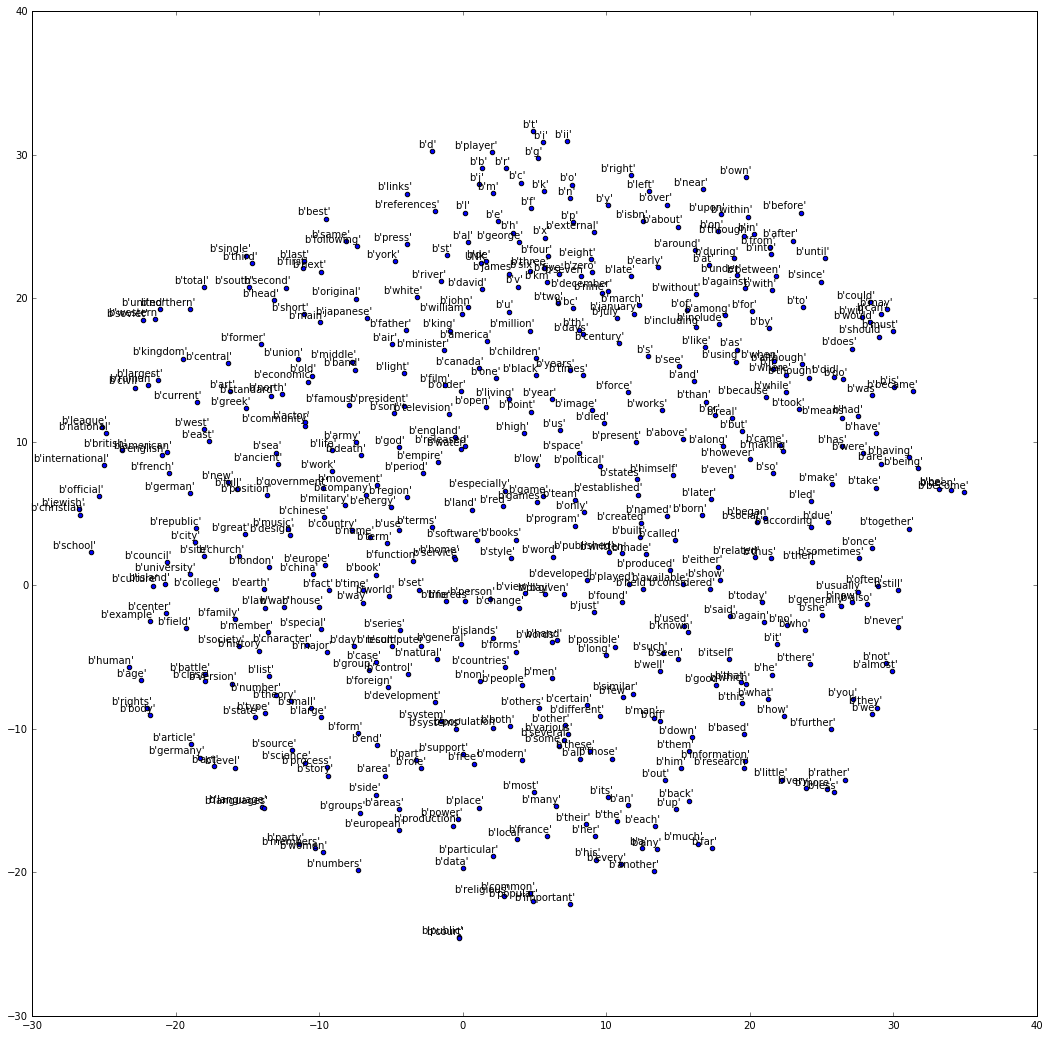

In [22]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
    
# Plot
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)